# Random Forest Classifier in PySpark - Lab

## Introduction  

In this lab, you will build a Random Forest Classifier model to study the ecommerce behavior of consumers from a multi-category store. First, you will need to download the data to your local machine, then you will load the data from the local machine onto a Pandas Dataframe.

## Objectives  

* Use the kaggle eCommerce dataset in PySpark
* Build and train a random forest classifier in PySpark

## Instruction
* Accept the Kaggle policy and download the data from [Kaggle](https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data)
* For the first model you will only use the 2019-Nov csv data (which is still around ~2gb zipped)
* You will run this notebook in a new `pyspark-env` environment following [these setup instructions without docker](https://github.com/learn-co-curriculum/dsc-spark-docker-installation)

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime

In [2]:
from pyspark.sql import SparkSession  # entry point for pyspark

# instantiate spark instance
spark = (
    SparkSession.builder.appName("Random Forest eCommerce")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .master("local[*]")
    .getOrCreate()
)

23/09/06 12:57:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
path = "../archive/2019-Nov.csv"  # wherever path you saved the kaggle file to
df = spark.read.csv(path, header=True, inferSchema=True)
df.printSchema()  # to see the schema

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



If you want to use Pandas to explore the dataset instead of Pyspark, you have to use the `action` functions, which then means there will be a network shuffle. For smaller dataset such as the Iris dataset which is about ~1KB this is no problem. The current dataset may be too large, and may throw an `OutOfMemory` error if you attempt to load the data into a Pandas dataframe. You should only take a few rows for exploratory analysis if you are more comfortable with Pandas. Otherwise, stick with native PySpark functions. 

### Know your Customers

How many unique customers visit the site?

Did you notice the spark progress bar when you triggered the `action` function? The `show()` function is the `action` function which means the lazy evaluation of Spark was triggered and completed a certain job. `read.csv` should have been another job. If you go to `localhost:4040` you should be able to see 2 completed jobs under the `Jobs` tab, which are `csv` and `showString`. While a heavy job is getting executed, you can take a look at the `Executors` tab to examine the executors completing the tasks in parellel. Now, you may not see if we run this on a local machine, but this behavior should definitely be visible if you're on a cloud system, such as EMR.

### (Optional) Visitors Daily Trend

Does traffic flunctuate by date? Try using the event_time to see traffic, and draw the plots for visualization.

<Axes: xlabel='start_time'>

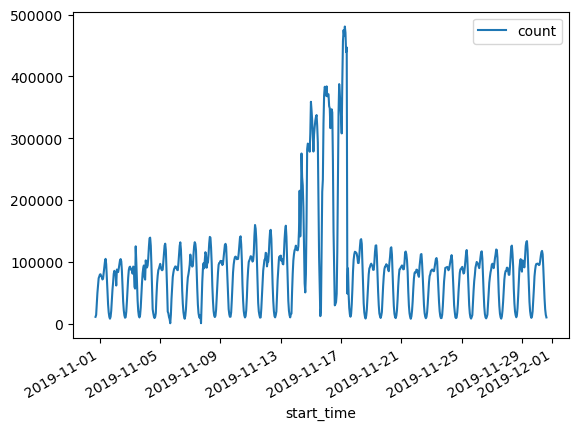

In [6]:
# for event_time you should use a window and groupby a time period
from pyspark.sql.functions import window

df_time = df.withColumn("hour", window(df.event_time, "1 hour"))
time_df_grouped = df_time.groupBy("hour").count().sort("hour").toPandas()
time_df_grouped["start_time"] = time_df_grouped.hour.str[0].values
time_df_grouped.plot(x="start_time", y="count")

Question: You would still like to see the cart abandonment rate using the dataset. What relevant features can we use for modeling?

In [7]:
# user_id, product_id, and event_type would be useful

Now, you will start building the model. Add the columns you would like to use for predictor features in the model to the `feature_cols` list

In [8]:

from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "user_id",
    "product_id",
    "category_id",
    "price",
]  # columns you'd like to use
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)
df.show()

+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand| price|  user_id|        user_session|            features|
+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+--------------------+
|2019-11-01 00:00:...|      view|   1003461|2053013555631882655|electronics.smart...|  xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|[5.20088904E8,100...|
|2019-11-01 00:00:...|      view|   5000088|2053013566100866035|appliances.sewing...|  janome|293.65|530496790|8e5f4f83-366c-4f7...|[5.3049679E8,5000...|
|2019-11-01 00:00:...|      view|  17302664|2053013553853497655|                null|   creed| 28.31|561587266|755422e7-9040-477...|[5.61587266E8,1.7...|
|2019-11-01 00:00:...|      view|   3601530|2053013563810775923|appliances.k

To use a string column, you can use the `StringIndexer` to encode the column. Update the `inputCol` keyword argument so that you can encode the target feature.

In [9]:
from pyspark.ml.feature import StringIndexer

labeler = StringIndexer(
    inputCol="event_type", outputCol="encoded"
)  # what should we use for the inputCol here?
df = labeler.fit(df).transform(df)
df.show()

+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+--------------------+-------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand| price|  user_id|        user_session|            features|encoded|
+--------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+--------------------+-------+
|2019-11-01 00:00:...|      view|   1003461|2053013555631882655|electronics.smart...|  xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|[5.20088904E8,100...|    0.0|
|2019-11-01 00:00:...|      view|   5000088|2053013566100866035|appliances.sewing...|  janome|293.65|530496790|8e5f4f83-366c-4f7...|[5.3049679E8,5000...|    0.0|
|2019-11-01 00:00:...|      view|  17302664|2053013553853497655|                null|   creed| 28.31|561587266|755422e7-9040-477...|[5.61587266E8,1.7...|    0.0|
|2019-11-01 00:00:...|      

Now build the train/test dataset with a 70/30 `randomSplit` and a random seed set to 42

In [10]:
train, test = df.randomSplit([0.7, 0.3], seed=42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 47253900


Test Dataset Count: 20248079


Next you need to add in the name of the feature column and the name of the `labelCol` you previously encoded for training the model.

In [11]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="encoded")
model = rf.fit(train)
predictions = model.transform(test)
# what goes in the select() function?
# predictions.select().show(25)

23/09/06 13:03:37 WARN MemoryStore: Not enough space to cache rdd_87_6 in memory! (computed 92.5 MiB so far)
23/09/06 13:03:37 WARN MemoryStore: Not enough space to cache rdd_87_0 in memory! (computed 92.5 MiB so far)
23/09/06 13:03:37 WARN BlockManager: Persisting block rdd_87_0 to disk instead.
23/09/06 13:03:37 WARN BlockManager: Persisting block rdd_87_6 to disk instead.
23/09/06 13:03:50 WARN MemoryStore: Not enough space to cache rdd_87_13 in memory! (computed 92.5 MiB so far)
23/09/06 13:03:50 WARN BlockManager: Persisting block rdd_87_13 to disk instead.
23/09/06 13:03:51 WARN MemoryStore: Not enough space to cache rdd_87_17 in memory! (computed 61.6 MiB so far)
23/09/06 13:03:51 WARN MemoryStore: Not enough space to cache rdd_87_11 in memory! (computed 61.6 MiB so far)
23/09/06 13:03:51 WARN BlockManager: Persisting block rdd_87_11 to disk instead.
23/09/06 13:03:51 WARN BlockManager: Persisting block rdd_87_17 to disk instead.
23/09/06 13:03:56 WARN MemoryStore: Not enough sp

Once the job execution is done, evaluate the model's performance. Add in the `labelCol` below.

In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="encoded", predictionCol="prediction"
)
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9132064981073577
Test Error = 0.08679350189264234


### Extra: Use the confusion matrix to see the other metrics